# Comparing the best grid for a typical region from different datasets

In [40]:
import xarray as xr
from minisom import MiniSom
import numpy as np
import pandas as pd
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
import glob
import xrft ## for detrend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
time_start = '1979-01-01'
time_end   = '2014-12-31'

domain_lonlat = {
    'EAS':{'lon_min':90,'lon_max':130,'lat_min':30,'lat_max':60},
    'EU':{'lon_min':10,'lon_max':50,'lat_min':35,'lat_max':65},
    'WNA':{'lon_min':220,'lon_max':260,'lat_min':25,'lat_max':55},
}

dataset_dir = {
    'era5':'/Users/zeqinhuang/Documents/paper/HWdna/dataset/era5_data/',
    'jra55':'/Users/zeqinhuang/Documents/paper/HWdna/dataset/jra55_data/',
    'ncep2':'/Users/zeqinhuang/Documents/paper/HWdna/dataset/ncep_data/'
}

In [3]:
## sel_domain(dataarray,lon_min,lon_max,lat_min,lat_max)
def sel_domain(dataarray,lon_min,lon_max,lat_min,lat_max):
    mask_lon = (dataarray.lon >= lon_min) & (dataarray.lon <= lon_max)
    mask_lat = (dataarray.lat >= lat_min) & (dataarray.lat <= lat_max)
    dataarray = dataarray.where(mask_lon & mask_lat, drop=True)
    return dataarray

In [301]:
## draw the m_neurons x n_neurons grid
'''
The 500hpa geopotential height anomalies in the Observed and ALL forcing data are computed by subtracting the seasonal cycle (calendar-day mean) 
of the historical period (1979~2014) from each grid cell as D.E Horton et al do. The anomalies from different external forcings are computed relatived to 
the historical period (1979~2014) of ALL forcing at the same way to generate comparative data.

ref: Horton, Daniel E., Nathaniel C. Johnson, Deepti Singh, Daniel L. Swain, Bala Rajaratnam, and Noah S. Diffenbaugh. 
“Contribution of Changes in Atmospheric Circulation Patterns to Extreme Temperature Trends.” Nature 522, no. 7557 (June 2015): 465–69. https://doi.org/10/f7hcw7.
'''
def draw_mn_grid(dataset_name,n_neurons,m_neurons,domain):
    hgt_dir = dataset_dir[dataset_name]
    hgt_path = glob.glob(hgt_dir + dataset_name + '_daily_hgt_*.nc')[0]
    hgt_ds = xr.open_dataarray(hgt_path)
    hgt_ds = hgt_ds.sel(time=slice(time_start,time_end))
    if dataset_name == 'era5':
        hgt_ds = hgt_ds.rename({'longitude':'lon','latitude':'lat','time':'time'})
        hgt_ds = hgt_ds / 9.80665
    lon_min0 = domain_lonlat[domain]['lon_min']
    lon_max0 = domain_lonlat[domain]['lon_max']
    lat_min0 = domain_lonlat[domain]['lat_min']
    lat_max0 = domain_lonlat[domain]['lat_max']
    hgt_ds = sel_domain(hgt_ds, lon_min=lon_min0, lon_max=lon_max0, lat_min=lat_min0, lat_max=lat_max0)
    hgt_ds_summer = hgt_ds.sel(time=hgt_ds['time.season']=='JJA')
    hgt_ds_summer = hgt_ds_summer.groupby('time.dayofyear') - hgt_ds_summer.groupby('time.dayofyear').mean('time')

    lon = hgt_ds_summer['lon']
    lat = hgt_ds_summer['lat']

    hgt_ds_summer_stack = hgt_ds_summer.stack(z=('lon','lat'))
    hgt_ds_summer_stack = hgt_ds_summer_stack.values
    hgt_ds_summer_stack = pd.DataFrame(hgt_ds_summer_stack)
    hgt_ds_summer_stack = hgt_ds_summer_stack.to_numpy()
 
    som = MiniSom(n_neurons, m_neurons, hgt_ds_summer_stack.shape[1], sigma=0.5, learning_rate=.5,
                neighborhood_function='gaussian', random_seed=0)
    som.train(hgt_ds_summer_stack, 10000) # trains the SOM with 10000 iterations

    proj = pplot.Proj('pcarree', lon_0=180)
    fig, ax = pplot.subplots(ncols = n_neurons, nrows = m_neurons,share=3,wspace=(0),hspace=(0),
                                proj = proj,
                                width = 10)
    levels = [-150 + 15 * i for i in range(21)]
    cmap1 = cmaps.BlRe

    for i in range(n_neurons):
        for j in range(m_neurons):
            pattern1_flatten = som.get_weights()[i,j,:]
            pattern1 = np.reshape(pattern1_flatten,newshape=(len(lat),len(lon)),order='F')

            ax_num = i*m_neurons+j
            p1 = ax[ax_num].contourf(lon,lat,pattern1,levels = levels, alpha=0.75, 
                                extend = 'both',cmap=cmap1)
            ax[ax_num].format(lonlim=(lon_min0,lon_max0), latlim=(lat_min0,lat_max0),
                        coast=True, borders=True, labels=True, lonlines=20, latlines=10)

    fig.colorbar(p1,loc='b',width='0.75em',length=0.8)

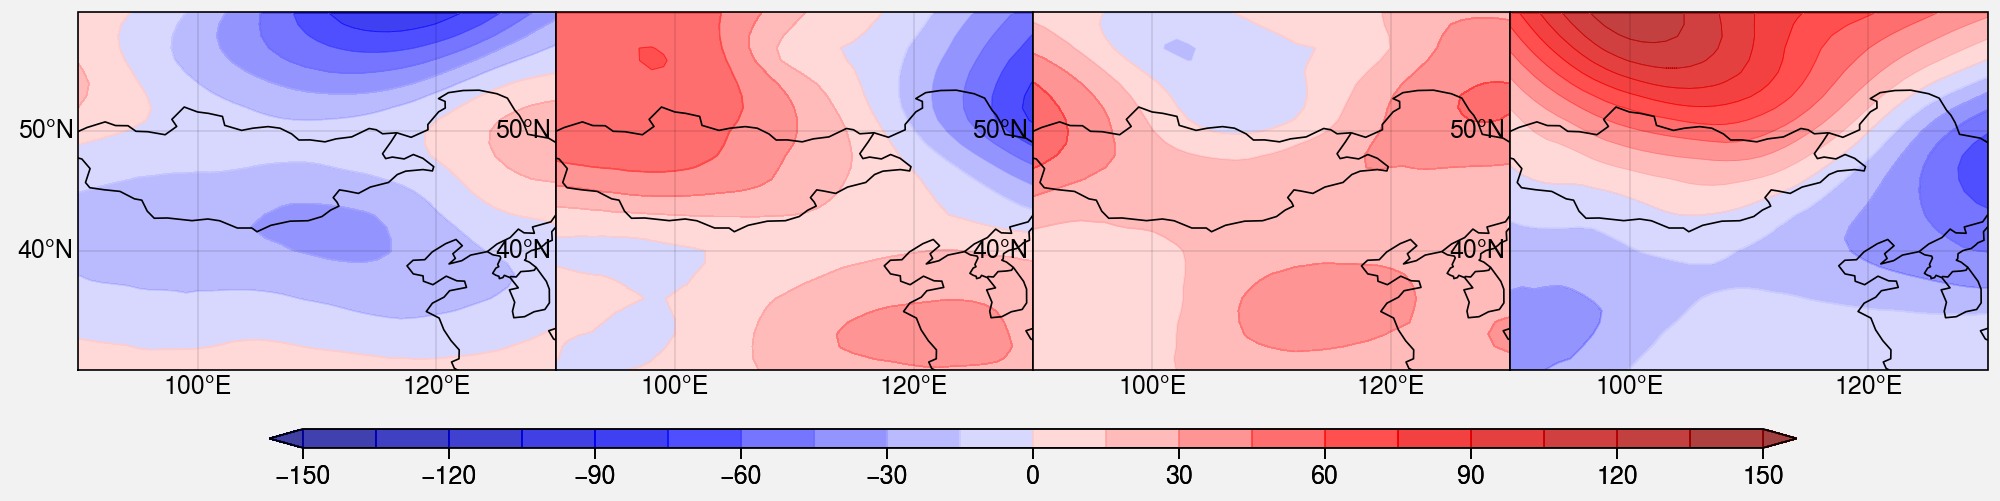

In [282]:
draw_mn_grid('era5',4,1,'EAS')

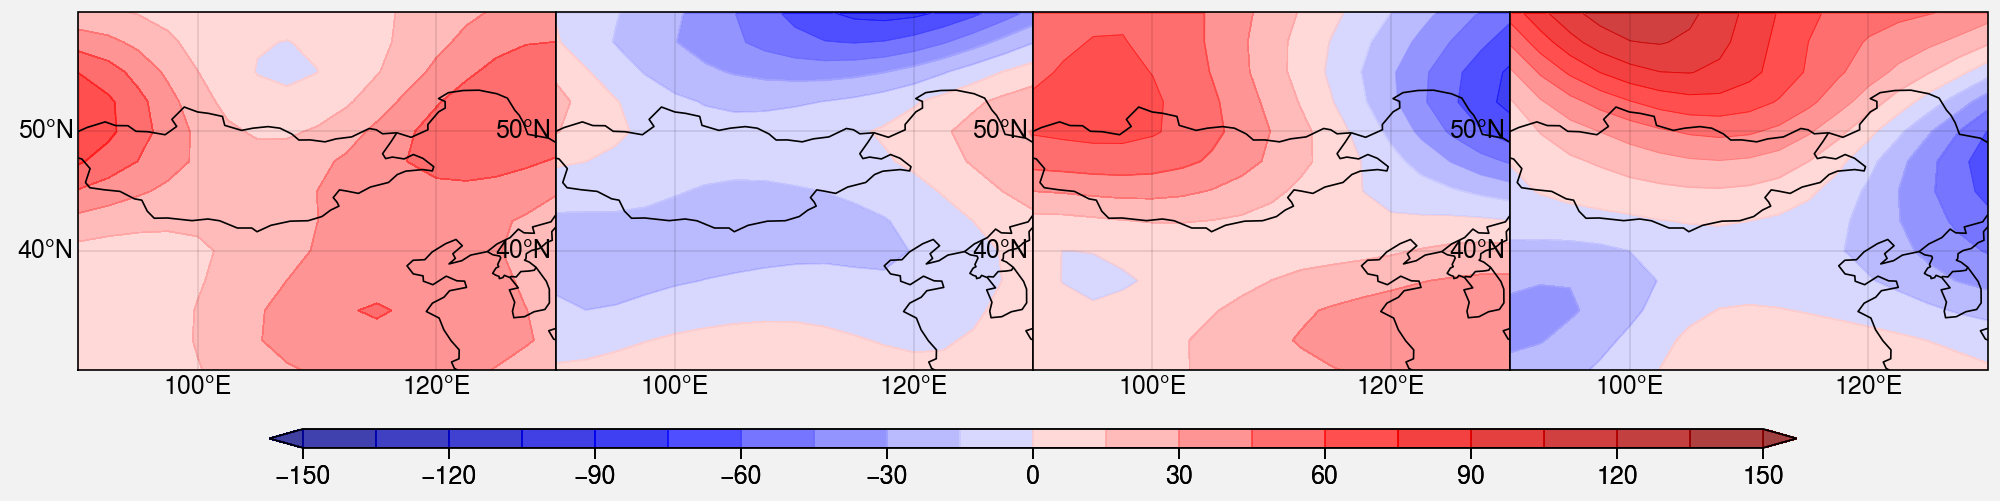

In [283]:
draw_mn_grid('ncep2',4,1,'EAS')

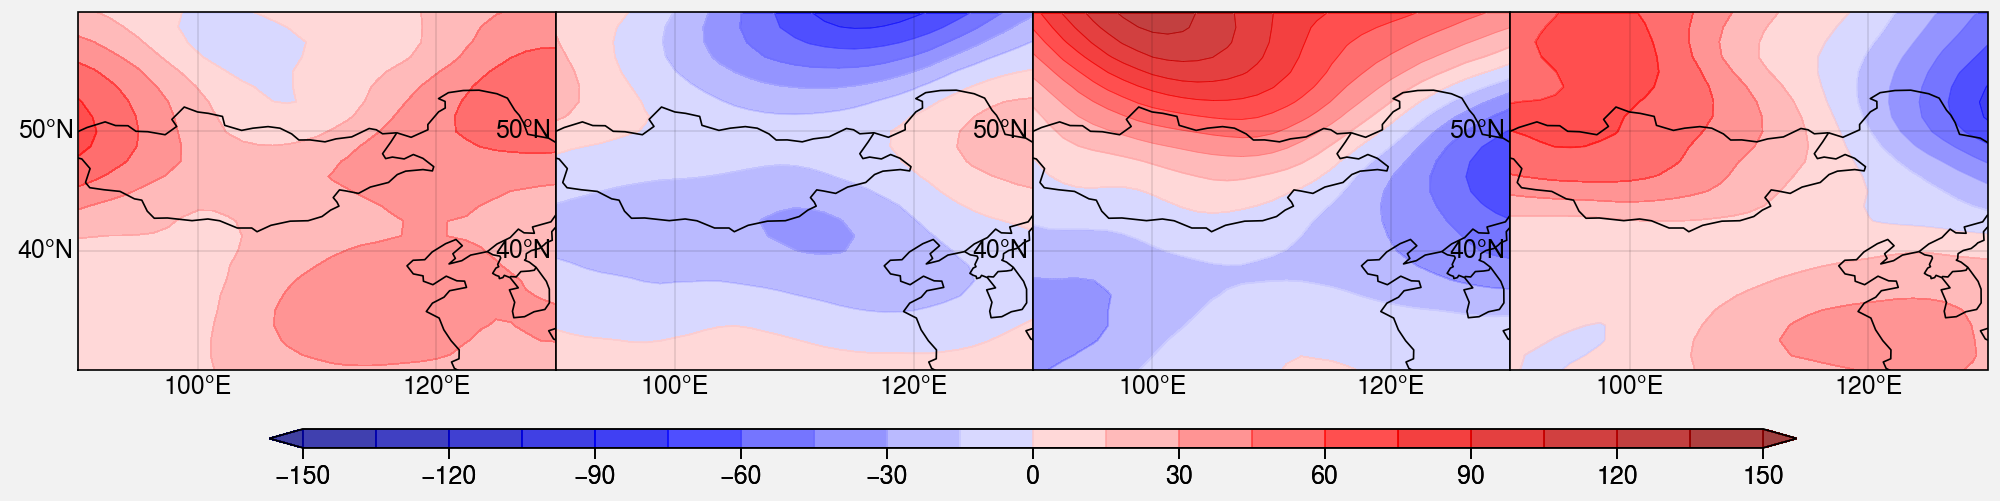

In [284]:
draw_mn_grid('jra55',4,1,'EAS')

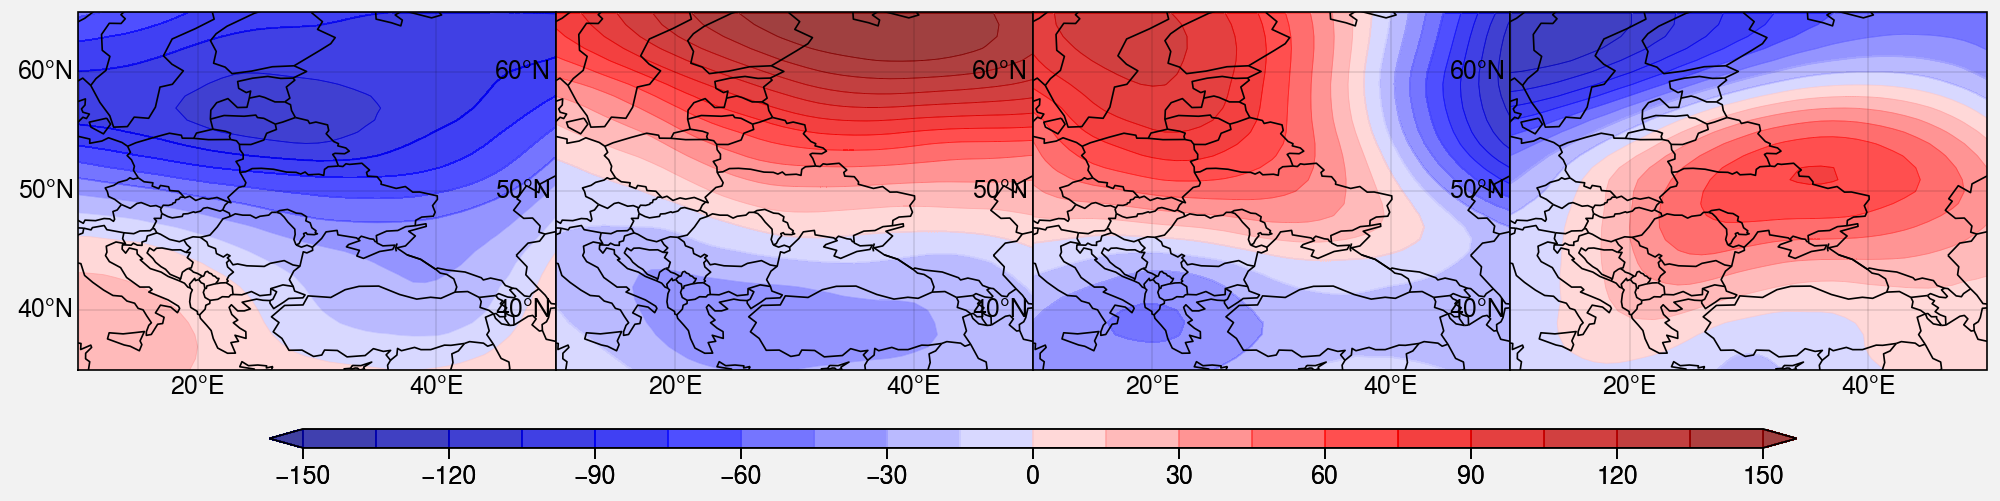

In [255]:
draw_mn_grid('era5',4,1,'EU')

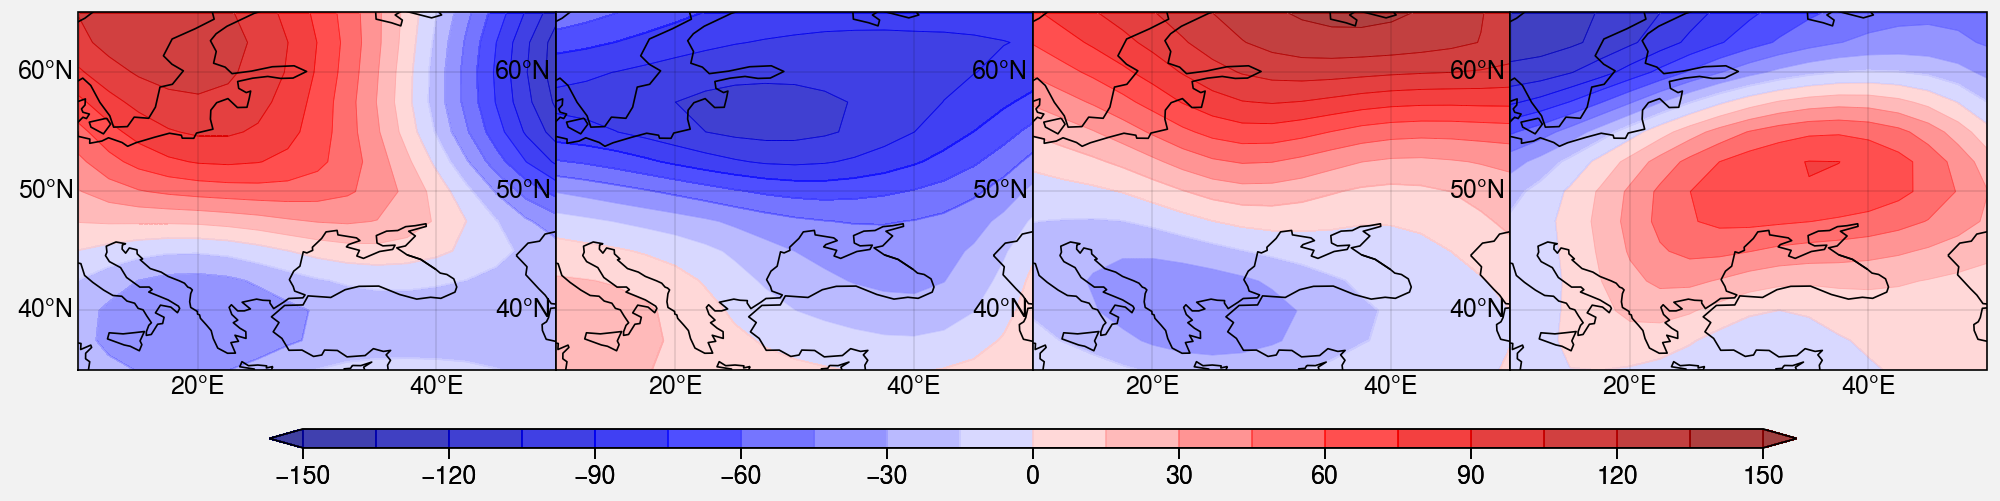

In [227]:
draw_mn_grid('ncep2',4,1,'EU')

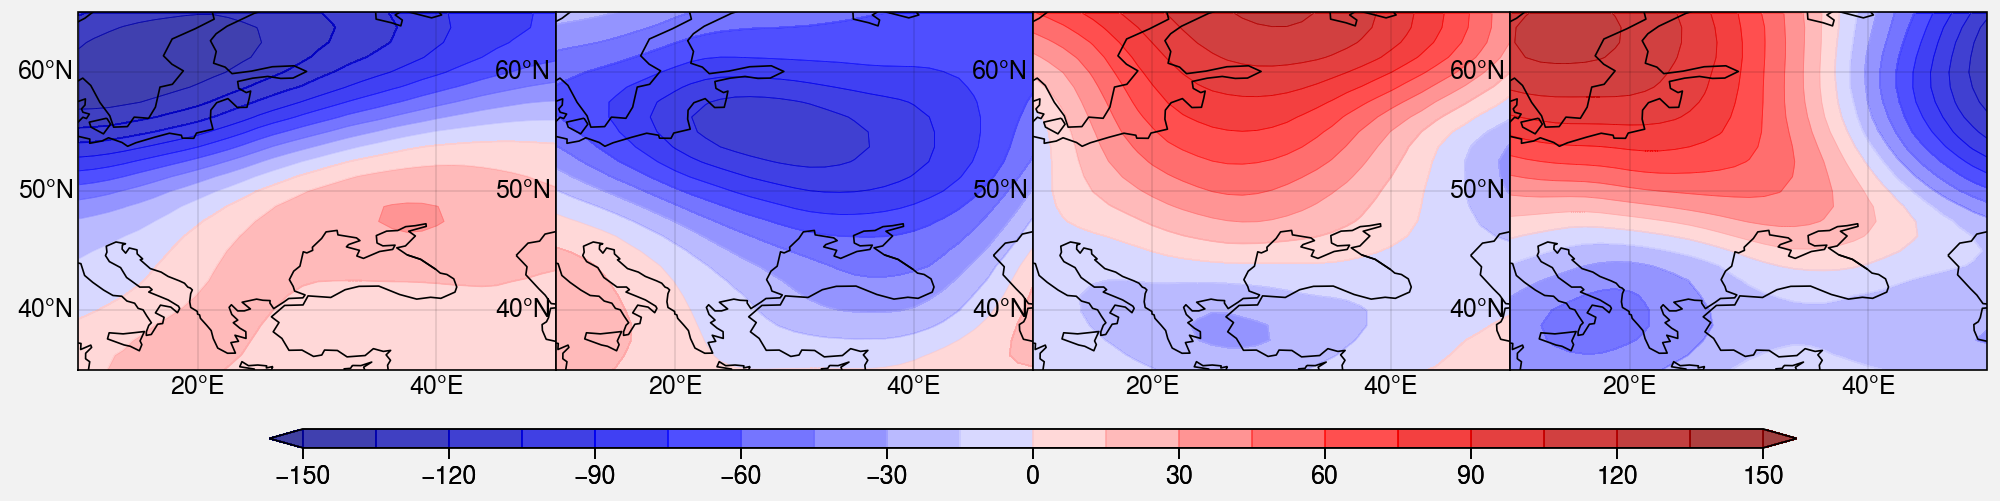

In [230]:
draw_mn_grid('jra55',4,1,'EU')

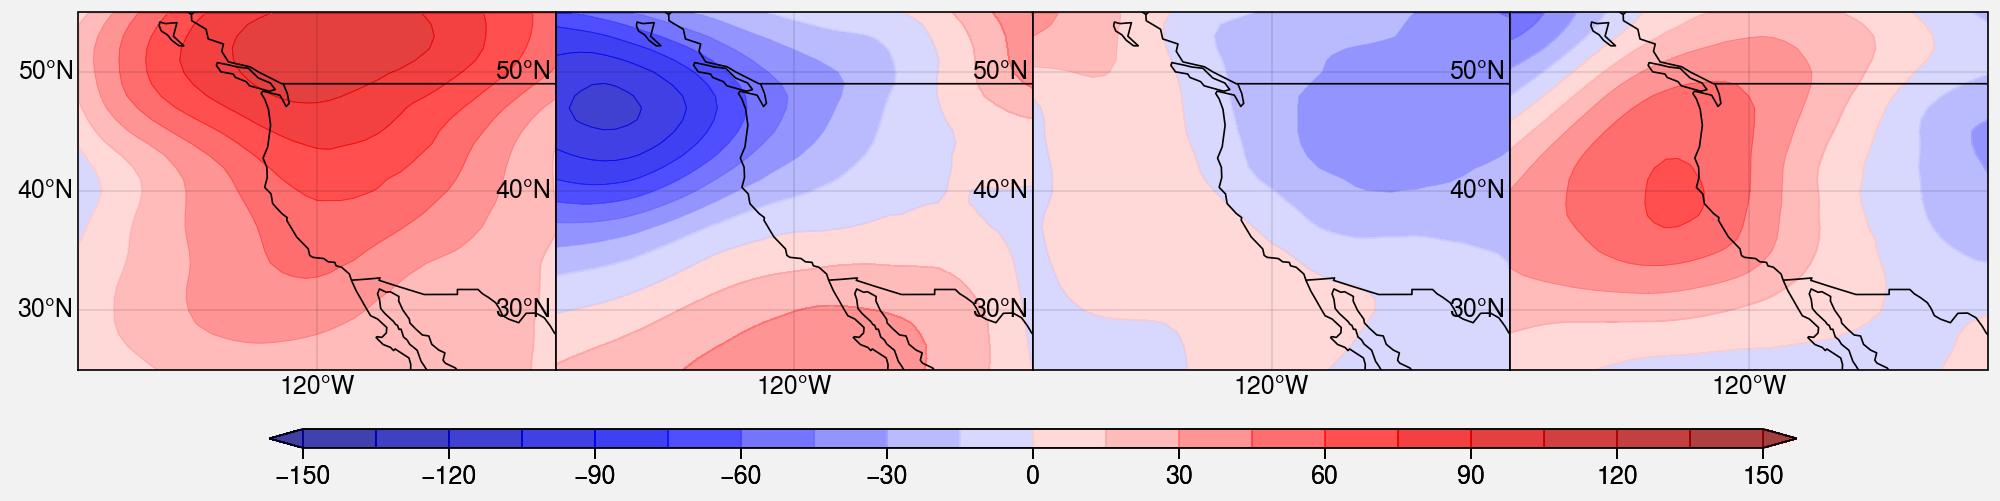

In [322]:
draw_mn_grid('era5',4,1,'WNA')

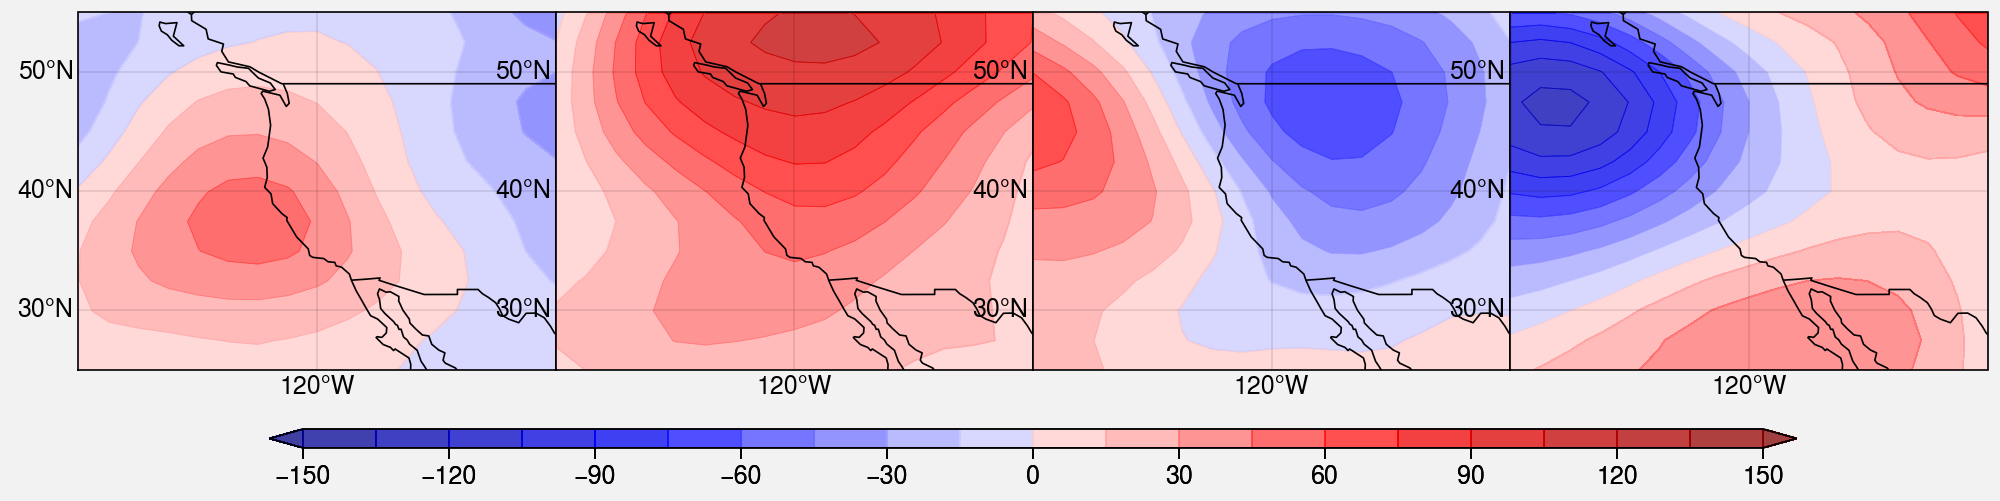

In [323]:
draw_mn_grid('ncep2',4,1,'WNA')

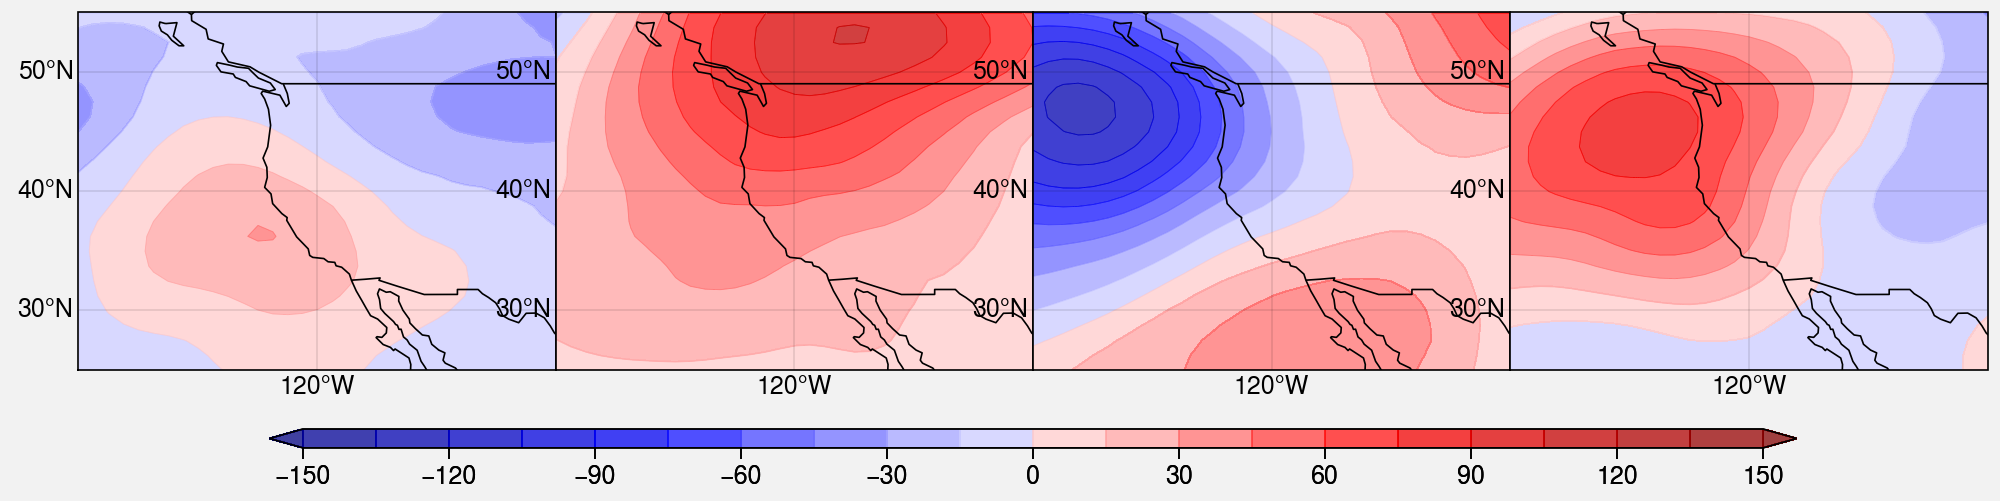

In [324]:
draw_mn_grid('jra55',4,1,'WNA')

# Determine the appropriate number of SOM patterns

In [99]:
'''
It is preferable that the number of SOM patterns be sufficiently large to identify more subtle features of GPH fields,
but small enough that the clusters are distinctive from each other
'''
def get_best_grid_preproc(dataset_name,domain): # dataset name must be one of ['era5','jra55','ncep2']
    hgt_dir = dataset_dir[dataset_name]
    hgt_path = glob.glob(hgt_dir + dataset_name + '_daily_hgt_*.nc')[0]
    hgt_ds = xr.open_dataarray(hgt_path)
    hgt_ds = hgt_ds.sel(time=slice(time_start,time_end))
    if dataset_name == 'era5':
        hgt_ds = hgt_ds.rename({'longitude':'lon','latitude':'lat','time':'time'})
        hgt_ds = hgt_ds / 9.80665
    lon_min0 = domain_lonlat[domain]['lon_min']
    lon_max0 = domain_lonlat[domain]['lon_max']
    lat_min0 = domain_lonlat[domain]['lat_min']
    lat_max0 = domain_lonlat[domain]['lat_max']
    hgt_ds = sel_domain(hgt_ds, lon_min=lon_min0, lon_max=lon_max0, lat_min=lat_min0, lat_max=lat_max0)
    hgt_ds_summer = hgt_ds.sel(time=hgt_ds['time.season']=='JJA')

    hgt_ds_summer_stack = hgt_ds_summer.stack(z=('lon','lat'))
    hgt_ds_summer_stack = hgt_ds_summer_stack.values
    hgt_ds_summer_stack = pd.DataFrame(hgt_ds_summer_stack)
    hgt_ds_summer_stack = hgt_ds_summer_stack.to_numpy()
    return hgt_ds_summer_stack

In [47]:
def get_best_grid2(n_neurons_list, m_neurons_list):
    fig,ax = plt.subplots(1, 3, sharex=False, figsize=(10,3))
    plt.rcParams["axes.grid"] = False
    markers = ['*','^','o']
    colors = ['red','blue','green']

    for d in range(3):
        domain = ['EU','EAS','WNA'][d]
        for dn in range(3):
            data_name = ['era5','jra55','ncep2'][dn]
            data = get_best_grid_preproc(dataset_name=data_name,domain=domain)
            if len(n_neurons_list) != len(m_neurons_list):
                raise ValueError('n_neurons_list and m_neurons_list must have the same length')
            else:
                grid_nums = len(n_neurons_list)
            if isinstance(data,np.ndarray) == False:
                raise TypeError('data must be numpy.ndarray with n*m dimensions, n is time dimension m location dimension')
            dist_list = []
            pair_list = []
            pattern_cor_list = []
            data_ano = data
            
            for n in range(grid_nums):
                n_neurons = n_neurons_list[n]
                m_neurons = m_neurons_list[n]
                som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=0.8, learning_rate=.5, 
                        neighborhood_function='gaussian', random_seed=0)
                som.train(data, 20000) # trains the SOM with 10000 iterations
                dist_map = som.distance_map()
                key_grid_i = np.where(dist_map == 1.)[0][0]
                key_grid_j = np.where(dist_map == 1.)[1][0]
                neighbor_i_max = key_grid_i + 1 if (key_grid_i + 1)< n_neurons else key_grid_i
                neighbor_i_min = key_grid_i - 1 if (key_grid_i - 1)>= 0 else key_grid_i
                neighbor_j_max = key_grid_j + 1 if (key_grid_j + 1)< m_neurons else key_grid_j
                neighbor_j_min = key_grid_j - 1 if (key_grid_j - 1)>= 0 else key_grid_j

                key_grid_dist = sum([som._euclidean_distance(som.get_weights()[key_grid_i,key_grid_j,:],som.get_weights()[i,j,:]) for i in range(neighbor_i_min,neighbor_i_max + 1) for j in range(neighbor_j_min,neighbor_j_max + 1)])
                pair_grid = []
                if n_neurons == 1 and m_neurons != 1:
                    pair_grid = [m_neurons - 1]
                    all_pair_num = sum(pair_grid)
                elif n_neurons != 1 and m_neurons == 1:
                    pair_grid = [n_neurons - 1]
                    all_pair_num = sum(pair_grid)
                else:
                    for i in range(n_neurons):
                        for j in range(m_neurons):
                            if (i == 0 or i == n_neurons - 1) and (j == 0 or j == m_neurons - 1):
                                pair_grid.append(3)
                            elif ((i == 0 or i == n_neurons - 1) and (j != 0 and j != m_neurons - 1)) or ((i != 0 and i != n_neurons - 1) and (j == 0 or j == m_neurons - 1)):
                                pair_grid.append(5)
                            else:
                                pair_grid.append(8)  
                    all_pair_num = sum(pair_grid) / 2
                
                pair_list.append(all_pair_num)
                all_grid_dist = np.sum(key_grid_dist * dist_map)/2/all_pair_num
                dist_list.append(all_grid_dist)

                winner_coordinates = np.array([som.winner(x) for x in data]).T
                pattern_cor = [np.corrcoef(data_ano[n,:],som.get_weights()[winner_coordinates[0,n],winner_coordinates[1,n],:])[0,1] for n in range(len(data_ano))]
                pattern_cor_mean = np.mean(pattern_cor)
                pattern_cor_list.append(pattern_cor_mean)

            ax[d].plot(np.arange(grid_nums),pattern_cor_list,label='Pattern correlation',color = colors[dn],markersize=6,marker = markers[dn],alpha=0.6)
            ax[d].plot(np.arange(grid_nums),pattern_cor_list,'-',label='Pattern correlation',color = colors[dn],linewidth=1.5,alpha=0.6)

        grid_label = [str(n_neurons_list[i])+'x'+str(m_neurons_list[i]) for i in range(grid_nums)]
        ax[d].set_xlabel('SOM grid')
        ax[d].set_xticks(np.arange(grid_nums))
        ax[d].set_xticklabels(grid_label)
        ax[d].set_ylabel('Pattern correlation',fontdict={'fontsize':10})
        ax[d].text(0.42,1.05,s = domain,fontdict={'fontsize':12,'weight':'bold'}, transform=ax[d].transAxes)
        ax[d].xaxis.set_tick_params(which='minor', bottom=False)
    
    legend_elements = [
        Line2D([0], [0], marker='*' ,color=colors[0],markerfacecolor=colors[0], label='ERA5',alpha=0.8,markersize=10),
        Line2D([0], [0], marker='^' ,color=colors[1],markerfacecolor=colors[1], label='JRA55',alpha=0.8,markersize=7),
        Line2D([0], [0], marker='o' ,color=colors[2],markerfacecolor=colors[2], label='NCEP2',alpha=0.8,markersize=7)]
    # handles = legend_elements
    ax[0].legend(handles=legend_elements,frameon=False,ncol=1,loc='lower right') 
    plt.tight_layout()
    fig_dir = '/Users/zeqinhuang/Documents/paper/HWdna/HWdna_figure_res/'
    fig.savefig(fig_dir+'FigS1_best_grid_selected_for_SOM_analysis.pdf')

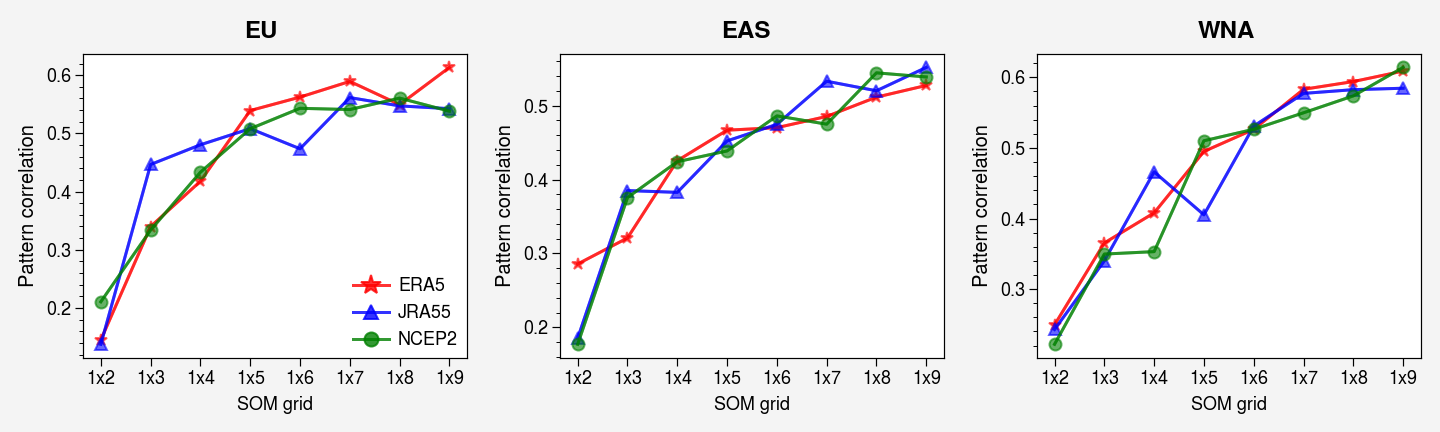

In [48]:
get_best_grid2([1,1,1,1,1,1,1,1],[2,3,4,5,6,7,8,9])